# A first analysis of the Galactic Center
In this tutorial, we will examine the basic elements of an Analysis.  The main object we will manipulate is the Analysis class, which contains a variety of helper functions to simplify adding, removing, and manipulating the templates we want to fit, as well as the fit masks, and some basic visualization of results.  

The methods in GammaLike are fully documented.  In ipython/jupyter notebooks you can use shift+tab to view the docstring of a function. 



First, let's load the anlaysis from the previous tutorial. 

In [1]:
import sys
sys.path.append('/data/GammaLike/')
from GammaLike import Analysis

basepath = '/data/GammaLike/testing/'
tag = 'P8R2_CLEAN_V6_calore' 
A = Analysis.Load(basepath+tag+'.GLanalysis')

# Adding the Fermi diffuse model template

For now we will just use the Fermi diffuse model.  Later we will learn how to use Galprop's output to construct our own diffuse model.  The Fermi template contains the $\pi^0$, ICS, and bremstrahlung contributions of the Galactic diffuse emission.  For diffuse analysis in the Galactic plane, this is not the best to use since it is optimized for point source analysis.  Beyond the Pass 6 models, these also contain Fermi Bubbles, Loop 1, and empirical corrections for bright ICS regions. 

We can simply add the diffuse model to the analysis by calling Analysis.AddFermiDiffuseModel() which will convert the Fermi model to the healpix grid and convolve it with the IRFs. 

In [2]:
A.AddFermiDiffuseModel(diffuse_path='/data/fermi_background_models/gll_iem_v06.fits',  # This is the Pass 8 diffuse model.
                       infile=None,       # Won't use this for now, but we can load the result by specifying infile
                       # Store the result by specifying outfile.  
                       # We will need this below to calculate point source masks.
                       outfile=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                       fixSpectrum=False) # Allow the spectrum to float in each energy bin. 

Remapping Fermi Diffuse Model to Healpix Grid 100.00 %


Now we need to also add the isotropic gamma-ray background template.  We need to specify a flux and flux uncertainty for the default values, and the template is then pnealized according to the external $\chi^2$ prescription of http://arxiv.org/abs/1409.0042 Eq. (2.5).

In [3]:
A.AddIsotropicTemplate(
        isofile='/data/GCE_sys/IGRB_ackerman_2014_modA.dat', # See the appendix at the bottom of the file. 
        fixNorm=False, fixSpectrum=False) 

We would also like to add the fixed point source template which we already generated. We also need to mask the point sources.  GammaCAP uses the adaptive masking scheme of http://arxiv.org/abs/1409.0042 Eq. (2.6)

In [4]:
A.AddPointSourceTemplate(fixNorm=True, # Fix the template normalization in all bins.
                         pscmap=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy') # This was generated in the first tutorial

A.CalculatePixelWeights(diffuse_model=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                        psc_model=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1) # see 1409.0042 Eq.(2.6)


Normally we would also add the Fermi Bubbles template, but this is already included in the Fermi background model.  We will see in later tutorials how to add this component. 

# Masking and choosing the ROI

GammaLike includes easy tools for masking and choosing the ROI, and one can specify arbitrary weights to each pixel.  More complex masking routines will be shown later and allow us to split templates into rings or subregions, for example.   Here we will reproduce the Calore 2015 analysis window over the inner Galaxy.  This is a square window centered on the Galactic Center running from +20 to -20 in lat/lon, with the plane $|b|<2^\circ$ masked out. 

In [5]:
_ =A.GenSquareMask(l_range=[-20.,20.], b_range=[-20.,20.], plane_mask=2.)

# Adding a dark matter template

We can now generate a dark matter template and add it to the fit. Let's start with an NFW profile with inner slope $\alpha=1.25$

In [6]:
_ = A.AddDMTemplate(profile='NFW', # Can be 'Ein', 'NFW', or 'Bur'
                limits=[None,None], 
                decay=False,     # Annihilation or decay? 
                gamma=1.25,      # Inner Slope
                r_s=20.0,        # NFW Scale radius 
                axesratio=1,     # Can skew the projected profile 
                offset=(0, 0),   # Can offset the profile 
                spec_file=None,) # Can specify a spectrum if we want 

Now we can look at the templates which are included in the fit via A.PrintTemplates().  

The output tells us the fitting specifications of each template.  SRCCLASS is used internally, so disregard this at the moment. 

In [7]:
A.PrintTemplates()

                NAME                    LIMITS      VALUE    FIXNORM    FIXSPEC   SRCCLASS
                 PSC              [None, None]  1.000e+00       True       True        PSC
                  DM              [None, None]  1.000e+00      False      False        GEN
        FermiDiffuse              [None, None]  1.000e+00      False      False        GEN
           Isotropic              [None, None]  1.000e+00      False      False        ISO


# Visualize the Templates. 

Let's use healpy to plot our templates over the ROI. We can access the template objects directly for lower level control.  See the docs for more information on this. 

-c:5: RuntimeWarning: invalid value encountered in log10


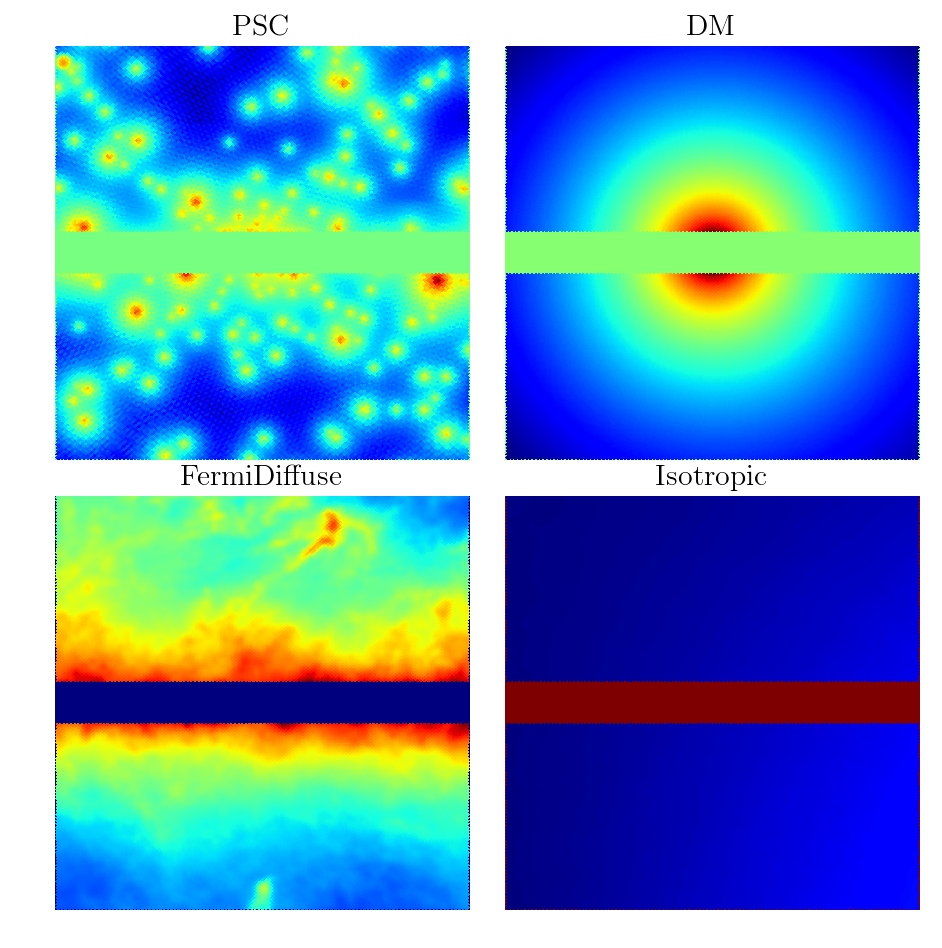

In [8]:
import healpy 

plt.figure(figsize=(6,6))
for i, (key, t) in enumerate(A.templateList.items()):
    healpy.cartview(np.log10(t.healpixCube[10])*A.mask, # just picking the 10th energy bin. Masking is applied in fitting only
                    lonra=(-20,20), latra=(-20,20), 
                    title=key,
                    sub=(2,2,i+1), 
                    cbar=False)

# Running the Fit.

Now we load our binned photon data and run the fit in each energy bin. The output is very long, but should be readable.  The normalization and errors are in the input template units.  Fit convergence is improved if these are normalized similarly. For some models, you may need to play with  limits on each template to get convergence.

In [9]:
A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')
A.RunLikelihood(print_level=0) # Set print_level to 1 if you want to see the output

(None, None, None)

# Analyzing the fit results. 

## Component Spectra

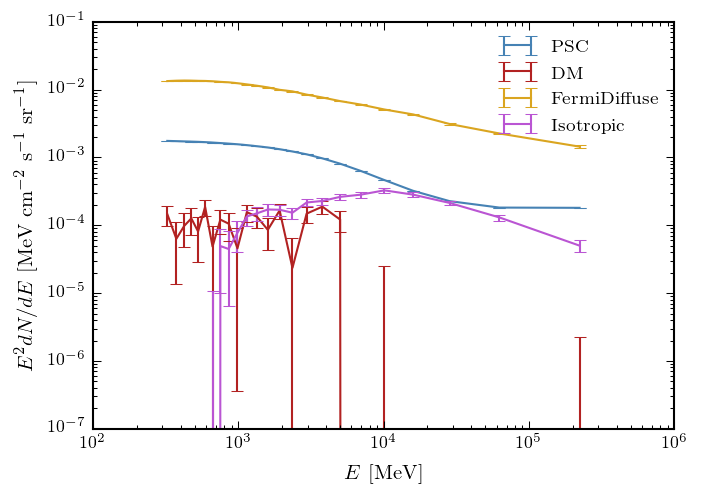

In [10]:
for key in A.templateList.keys():
    # Get the flux and uncertainties averaged over the masked area. 
    E, flux, fluxunc = A.GetSpectrum(key) 
    # Plot the SED 
    plt.errorbar(E, E**2*flux, yerr=E**2*fluxunc.T, label=key)
    
plt.legend(frameon=False)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$E$ [MeV]')
plt.ylabel(r'$E^2 dN/dE \rm\ [MeV\ cm^{-2}\ s^{-1}\ sr^{-1}]$')


## Plot Residuals

Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


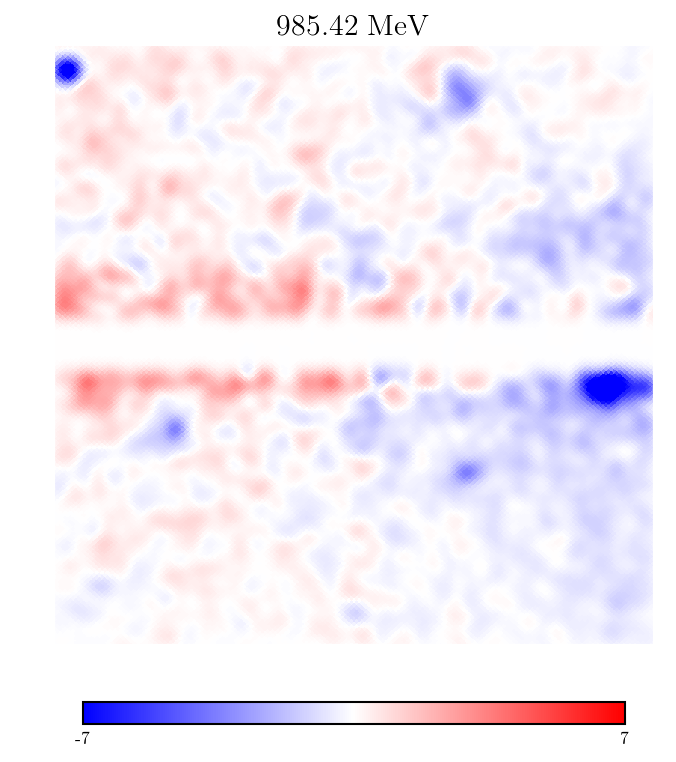

In [11]:
from scipy import ndimage

def PlotResidual(E):
    res = A.GetResidual() # Get the residual emission
    # We can pick the closest bin to the requested energy 
    closest_bin = np.argmin(np.abs(A.central_energies-E))
    
    # Let's smooth it with a .5 deg gaussian 
    smoothed_residual = healpy.smoothing(res[closest_bin]*A.mask, sigma=.5 * np.pi/180)

    healpy.cartview(smoothed_residual, 
                    lonra=(-20,20), latra=(-20,20), 
                    title='%1.2f MeV'%A.central_energies[closest_bin],
                    min=-7, max=7, cmap='bwr')
    
    
PlotResidual(1e3)

# Appendix A: The IGRB flux. 

In [12]:
# Copy this into a file (without the quotes)  Flux and uncertainties from Ackerman 2014 Mod A 
# Columns are energy in MeV, dF/dE in [cm^-2 s^-1 sr^-1 GeV^-1], and flux uncertainty in the same units. 
_ = '''
1.189117319695580761e+02 6.688405797101448344e-08 1.330676328502415173e-08
1.681665840766233941e+02 2.902730375426621627e-08 7.365187713310580518e-09
2.378234639391159533e+02 1.276570048309178518e-08 3.734299516908212025e-09
3.363331681532465041e+02 5.674061433447099126e-09 1.697952218430034233e-09
4.756889740155851314e+02 2.707302353651175919e-09 6.077248038624017140e-10
6.727257985241833467e+02 1.389671361502347637e-09 1.720017072129748487e-10
9.513779480311703765e+02 5.829812914906455811e-10 6.617380808690402529e-11
1.345451597048366693e+03 2.281263337601366040e-10 2.742210840802390362e-11
1.902713851318688512e+03 9.099139882299685566e-11 1.239173079824958667e-11
2.690843733850034369e+03 4.195028272698174583e-11 4.425477435186172238e-12
3.805469747613297386e+03 1.757827235005658283e-11 2.278385514900037671e-12
5.381746928275244500e+03 7.794078420912242388e-12 1.271805814883969075e-12
7.610939495226595682e+03 3.614107883817427282e-12 5.563938136552244640e-13
1.076349385655049082e+04 2.032275273406241870e-12 2.636169645238730183e-13
1.522183694565145925e+04 7.618023727343025250e-13 1.008694996133461180e-13
2.152692825277214433e+04 3.532895000066684028e-13 4.354436457235833891e-14
3.044371593613374353e+04 1.462669395222512070e-13 1.778590895802487582e-14
4.305391596591418056e+04 7.008488873773848392e-14 8.328832163029055183e-15
6.088738982745104295e+04 2.989951762803133528e-14 3.734492660684563219e-15
8.610777247147889284e+04 1.202308592538751474e-14 1.666094297536367510e-15
1.217748216997257405e+05 3.644893965649349302e-15 6.768751989249213691e-16
1.722156044033176440e+05 1.632254999208128737e-15 3.400878560294742413e-16
2.435496013546317117e+05 5.559295021035965411e-16 1.607904666813625147e-16
3.444311493462809012e+05 2.664852866279734120e-16 9.060666454945484253e-17
4.870992447540854919e+05 4.320357133805526964e-17 3.336635980146396416e-17
6.888623581529194489e+05 1.752952115566473410e-19 9.310734726998338704e-18
'''

# Appendix B: All the code together. 

This is useful to initiate an analysis generically. 

In [13]:
from GammaLike import Analysis

basepath = '/data/GammaLike/testing/'
tag = 'P8R2_CLEAN_V6_calore' 
A = Analysis.Load(basepath+tag+'.GLanalysis')


A.AddFermiDiffuseModel(diffuse_path='/data/fermi_background_models/gll_iem_v06.fits',  # This is the Pass 8 diffuse model.
                       infile=None,       # Won't use this for now, but we can load the result by specifying infile
                       # Store the result by specifying outfile.  
                       # We will need this below to calculate point source masks.
                       outfile=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                       fixSpectrum=False) # Allow the spectrum to float in each energy bin. 
A.AddIsotropicTemplate(
        isofile='/data/GCE_sys/IGRB_ackerman_2014_modA.dat', # See the appendix at the bottom of the file. 
        fixNorm=False, fixSpectrum=False) 

A.AddPointSourceTemplate(fixNorm=True, # Fix the template normalization in all bins.
                         pscmap=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy') # This was generated in the first tutorial

A.CalculatePixelWeights(diffuse_model=A.basepath+'/'+'fermi_diffuse_'+A.tag+'.npy',
                        psc_model=A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy',
                        alpha_psc=5., f_psc=0.1) # see 1409.0042 Eq.(2.6)

_ = A.GenSquareMask(l_range=[-20.,20.], b_range=[-20.,20.], plane_mask=2.)


_ = A.AddDMTemplate(profile='NFW', # Can be 'Ein', 'NFW', or 'Bur'
                limits=[None,None], 
                decay=False,     # Annihilation or decay? 
                gamma=1.25,      # Inner Slope
                r_s=20.0,        # NFW Scale radius 
                axesratio=1,     # Can skew the projected profile 
                offset=(0, 0),   # Can offset the profile 
                spec_file=None,) # Can specify a spectrum if we want 

A.BinPhotons(infile='binned_photons_'+A.tag+'.npy')

Remapping Fermi Diffuse Model to Healpix Grid 100.00 %
